<h1><center>Recurrent Neural Network in PyTorch</center></h1>

Table of Contents: <a id=100></a>

1. [Packages](#1)
2. [Data definition](#2)
    - 2.1 [Declaring a tensor `x`](#3)
    - 2.2 [Creating a tensor `y` as a sin function of `x`](#4)
    - 2.3 [Plotting `y`](#5)
3. [Batching the data](#6)
    - 3.1 [Splitting the data in train/test set](#7)
    - 3.2 [Creating the batches of data](#8)
4. [Defining the model](#9)
    - 4.1 [Model class](#10)
    - 4.2 [Model instantiation](#11)
    - 4.3 [Training](#12)
5. [Alcohol Sales dataset](#13)
    - 5.1 [Loading and plotting](#14)
    - 5.2 [Prepare and normalize](#15)
    - 5.3 [Modelling](#16)
    - 5.4 [Predictions](#17)

Рекуррентные нейронные сети - это тип нейронных сетей, которые предназначены для работы с моделями предсказания последовательности. RNN могут использоваться для текстовых данных, речевых данных, задач классификации и порождающих моделей. В отличие от ANN, предсказания RNN основаны на прошлом предсказании, а также на текущем вводе. RNN - это сети с петлями в них, позволяющими сохранять информацию.

Каждый узел **RNN** состоит из 2 входов:
1. Memory unit
2. Event unit

`M(t-1)` - это блок памяти или выходные данные предыдущего прогноза. `E(t)` - текущее событие или информация, предоставляемая в настоящее время. `M(t)` - это выходные данные текущего узла или выходные данные в настоящее время в последовательности.

### 1. Packages <a id=1></a>
[back to top](#100)

In [24]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Data definition <a id=2></a>
[back to top](#100)

Обучим простую модель LSTM, которая является типом архитектуры RNN, для прогнозирования временных рядов. Сделаем модельные данные **Sin**.

#### 2.1 Declaring a tensor `x` <a id=3></a>

In [25]:
x_data = torch.linspace(0, 799, 800)

#### 2.2 Creating a tensor `y` as a sin function of `x` <a id=4></a>

In [26]:
y_data = torch.sin(x_data * 2 * np.pi / 40)

#### 2.3 Plotting `y` <a id=5></a>

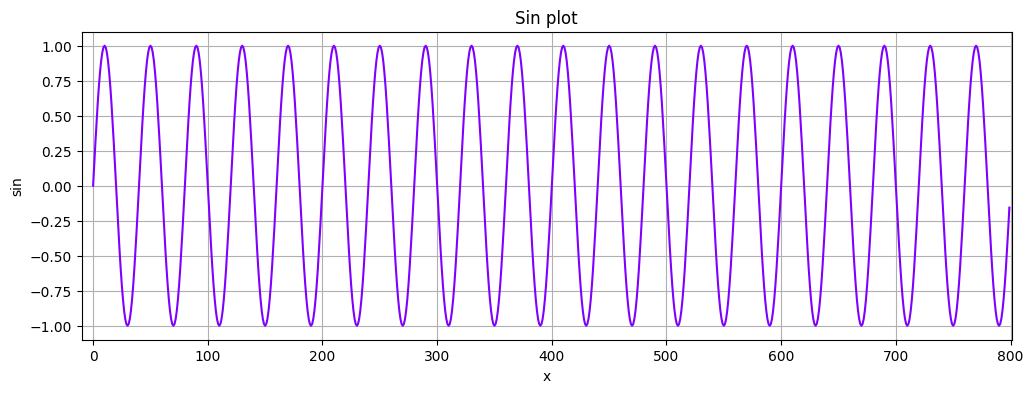

In [27]:
plt.figure(figsize=(12, 4))
plt.xlim(-10, 801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(y_data.numpy(), color='#8000ff')
plt.show()

### 3. Batching the data <a id=6></a>
[back to top](#100)

#### 3.1 Splitting the data in train/test set <a id=7></a>

In [28]:
test_size = 40  # один период
train_set = y_data[:-test_size]
test_set = y_data[-test_size:]

##### 3.1.1 Plotting the training/testing set

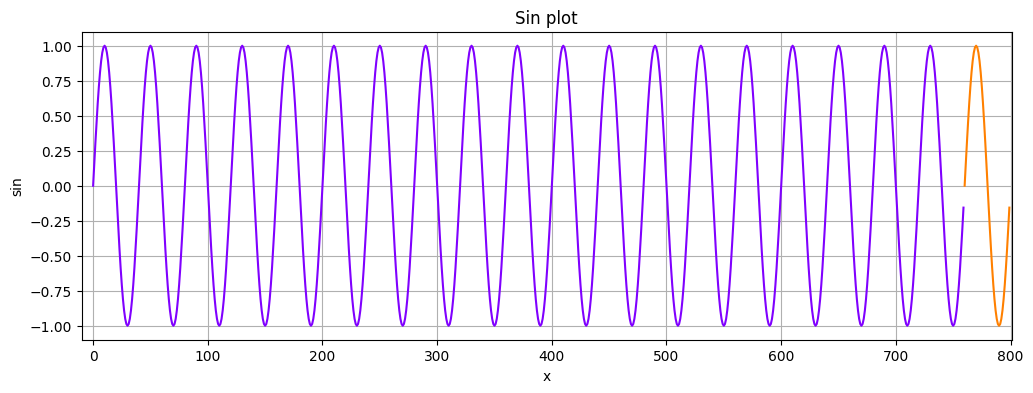

In [29]:
plt.figure(figsize=(12, 4))
plt.xlim(-10, 801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")

plt.plot(train_set.numpy(), color='#8000ff')  # train set
plt.plot(range(760, 800), test_set.numpy(), color="#ff8000")  # val set

plt.show()

#### 3.2 Creating the batches of data <a id=8></a>

При работе с моделями LSTM мы разделяем обучающую последовательность на серии перекрывающихся окон. Метка, используемая для сравнения, является следующим значением в последовательности.

Например, если у нас есть серия из 12 записей и размер окна равен 3, мы вводим `[x1, x2, x3]` в модель и сравниваем прогноз с `x4`. Затем мы берем последний эдемент, обновляем параметры и вводим `[x2, x3, x4]` в модель и сравниваем прогноз с `x5`. Чтобы облегчить этот процесс, определим функцию `input_data(seq, ws)`, которая создает список `(seq, labels)`. Если `ws` - это размер окна, то общее количество кортежей `(seq, labels)` будет равно `len(seq) - ws`.

In [30]:
def input_data(seq, ws):
    out = []
    
    for i in range(len(seq)- ws):
        window = seq[i: i + ws]
        label = seq[i + ws: i + ws + 1]
        out.append((window, label))
    
    return out

##### 3.2.1 Calling the `input_data` function
The length of `x` = 800

The length of `train_set` = 800 - 40 = 760

The length of `train_data` = 760 - 40 - 720

In [31]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

##### 3.2.2 Checking the 1st value from train_data

In [32]:
x, y = train_data[0]
len(x)

40

### 4. Defining the model <a id=9></a>
[back to top](#100)

#### 4.1 Model Class <a id=10></a>

`torch.nn.LSTM(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)`

*ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html*

In [33]:
class LSTMnetwork(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size

        self.num_layers = 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_size, out_size)        

    def init_hidden(self, x): 
        seq_len, bs, seq_dim = x.shape
        self.hidden = (torch.zeros(self.num_layers, bs, self.hidden_size), 
                       torch.zeros(self.num_layers, bs, self.hidden_size))
    
    def forward(self, x):
        self.init_hidden(x)

        lstm_out, self.hidden = self.lstm(x, self.hidden)
        pred = self.fc(lstm_out[-1, ...])  # get the last one 

        return pred

In [34]:
bs = 5
seq_len = 100
seq_dim = 1

x = torch.rand((seq_len, bs, seq_dim))
print('input shape', x.shape)

model = LSTMnetwork(input_size=seq_dim, hidden_size=100, out_size=1)

out = model(x)

print('output shape', out.shape)

input shape torch.Size([100, 5, 1])
output shape torch.Size([5, 1])


#### 4.2 Model Instantiation <a id = 11></a>

In [35]:
torch.manual_seed(42)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

##### 4.2.1 Printing the model

In [36]:
model

LSTMnetwork(
  (lstm): LSTM(1, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

#### 4.3 Dataset <a id = 12></a>

In [37]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
                    
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, item):
        sequence, label = self.data[item]
        
        seq = torch.tensor(sequence, dtype=torch.float32).view(-1, 1)
        label = torch.tensor(label, dtype=torch.float)
        
        return seq, label
    

def collate_fn_seq(batch):
    _x = torch.stack([x for x, y in batch]).transpose(1, 0)
    _y = torch.stack([y for x, y in batch])
    
    return _x, _y

In [38]:
train_dataset = CustomDataset(train_data)


In [39]:
batch_size = 1
n_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,       
                                           shuffle=True, 
                                           num_workers=n_workers,
                                           collate_fn=collate_fn_seq
                                           )

In [40]:
seq, label = next(iter(train_loader))
print(seq.shape, label.shape)

torch.Size([40, 1, 1]) torch.Size([1, 1])


/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(sequence, dtype=torch.float32).view(-1, 1)
/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


#### 4.4 Training <a id = 12></a>

During training, I'm visualising the prediction process for the test data on the go. It will give a better understanding of how the training is being carried out in each epoch. The training sequence is represented in <span style="color:#8000ff">purple</span> while the predicted sequence in represented in <span style="color:#ff8000">orange</span>.

In [41]:
def predict(model, x, pred_seq=40): 
    preds = x.copy()
    seq = torch.tensor(preds[-window_size:], dtype=torch.float)
    for _ in range(pred_seq):
        out = model(seq.view(len(seq), 1, -1))
        preds.append(out.item())

    return preds

/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(sequence, dtype=torch.float32).view(-1, 1)
/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


Epoch 0 Loss: 0.14169198274612427
Performance on test range: 0.6328088641166687


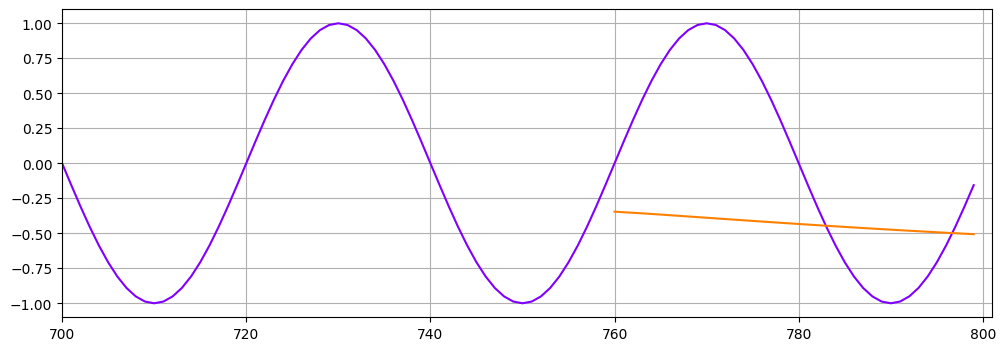

Epoch 1 Loss: 0.06479372084140778
Performance on test range: 0.5627778172492981


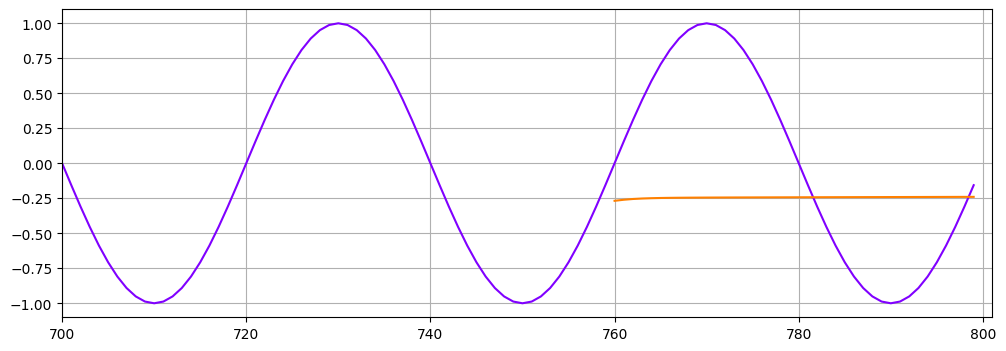

Epoch 2 Loss: 0.007693518418818712
Performance on test range: 0.59669029712677


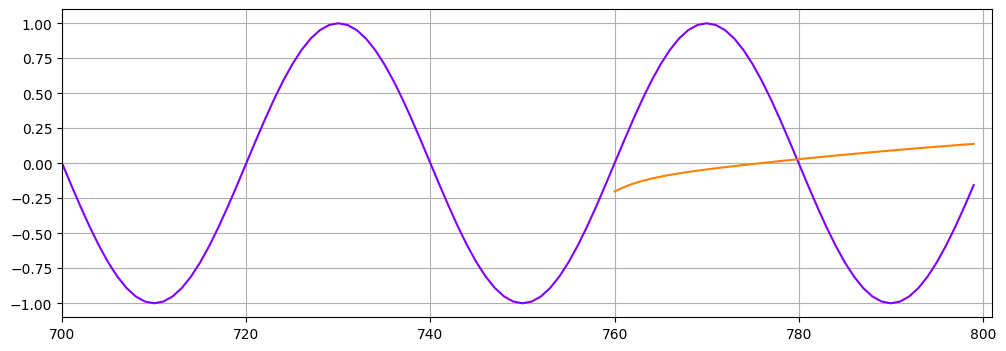

Epoch 3 Loss: 0.018197383731603622
Performance on test range: 0.5239569544792175


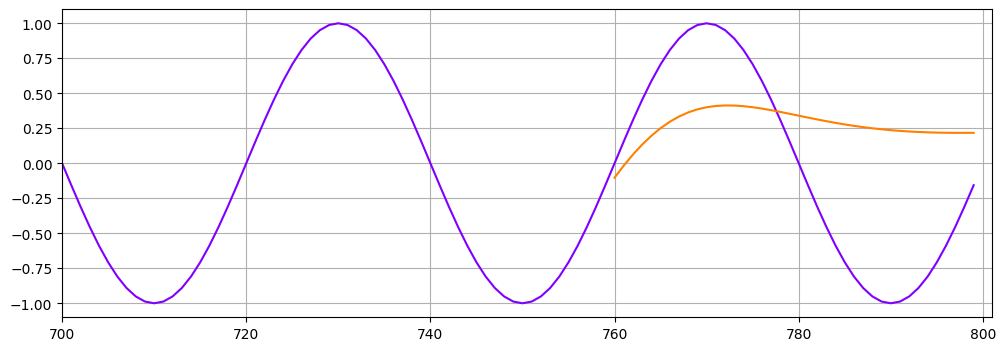

Epoch 4 Loss: 0.004669679794460535
Performance on test range: 0.09041939675807953


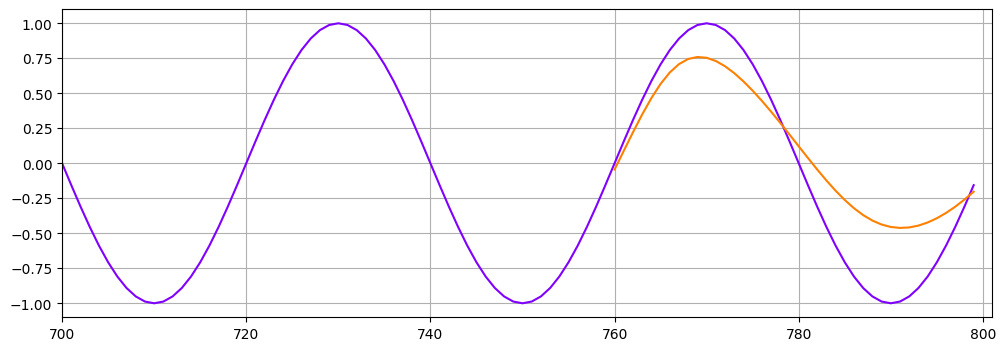

Epoch 5 Loss: 0.0005057851085439324
Performance on test range: 0.008585566654801369


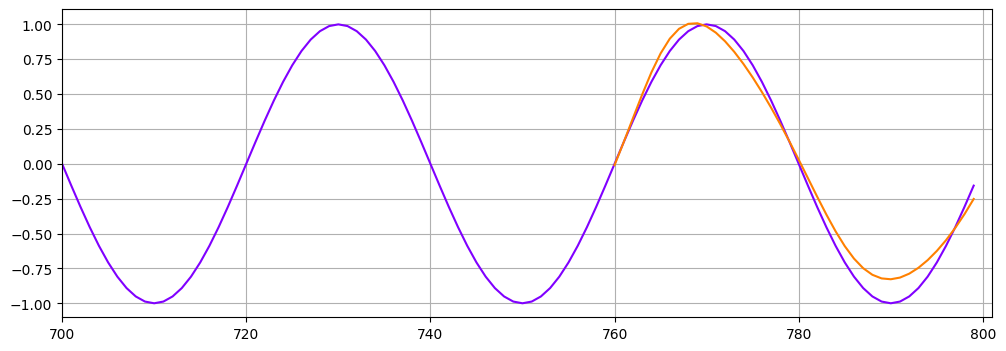

Epoch 6 Loss: 0.0005822548409923911
Performance on test range: 0.00910443626344204


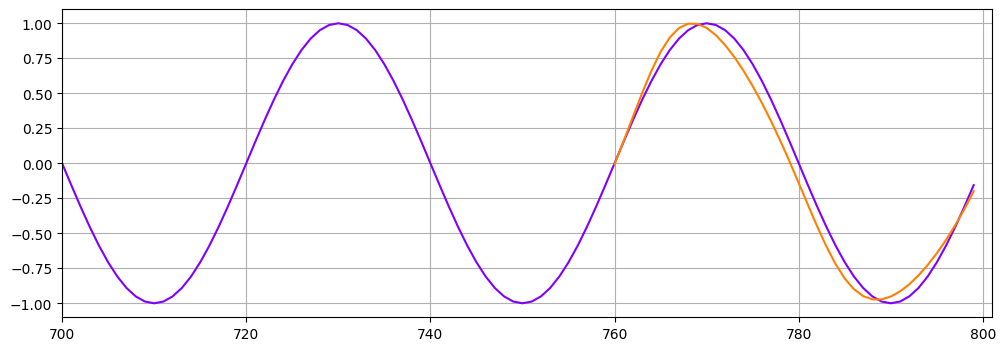

Epoch 7 Loss: 0.000198912137420848
Performance on test range: 0.006279603578150272


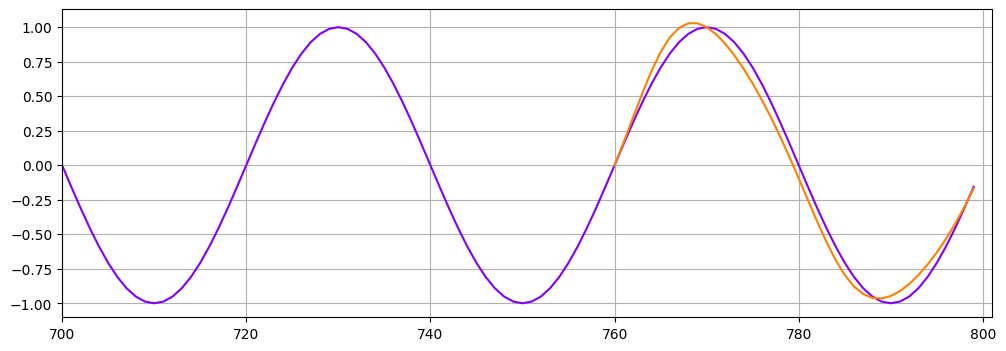

Epoch 8 Loss: 0.001308778184466064
Performance on test range: 0.009152176789939404


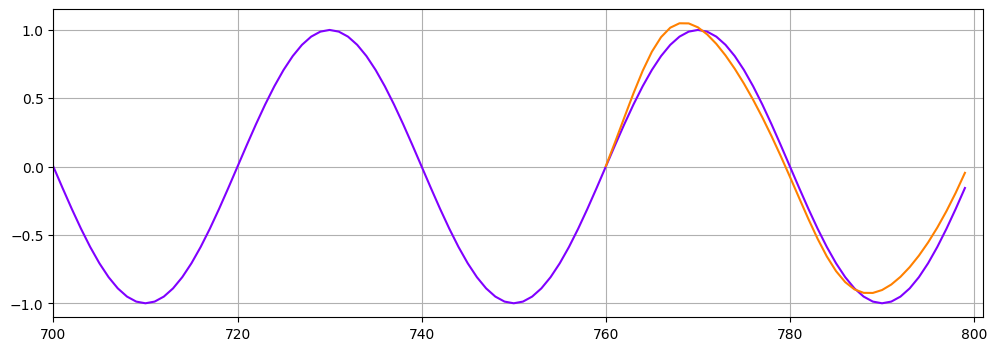

Epoch 9 Loss: 0.0003609748382586986
Performance on test range: 0.006633249577134848


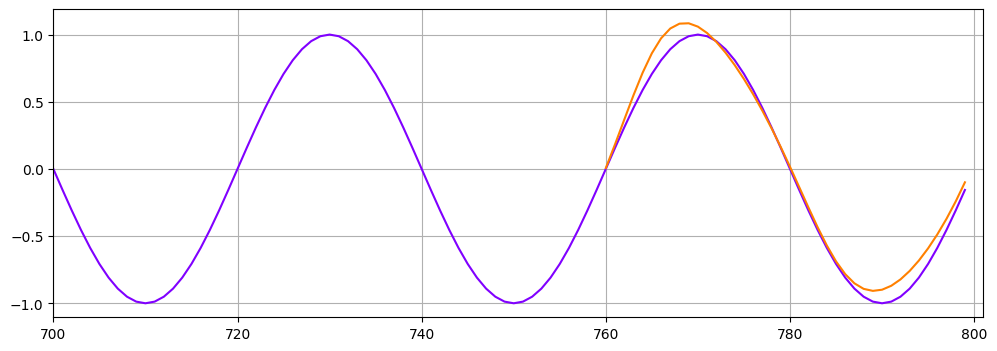

In [42]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_loader:
        optimizer.zero_grad()
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    # get one period for live test
    with torch.inference_mode():
        preds = train_set[-window_size:].tolist()
        for f in range(future):
            seq = torch.FloatTensor(preds[-window_size:])
            preds.append(model(seq.view(len(seq), 1, -1)).detach().item())

    loss = criterion(torch.tensor(preds[-window_size:]), test_set)
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y_data.numpy(),color='#8000ff')
    plt.plot(range(760,800), preds[window_size:],color='#ff8000')
    plt.show()

### 5. Alcohol Sales dataset <a id=13></a>
[back to top](#100)

#### 5.1 Loading and plotting <a id=14></a>

##### 5.1.1 Importing the data

In [43]:
df = pd.read_csv("Alcohol_Sales.csv", index_col = 0, parse_dates = True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


##### 5.1.2 Dropping the empty rows

In [44]:
df.dropna(inplace=True)
len(df)

325

##### 5.1.3 Plotting the Time Series Data

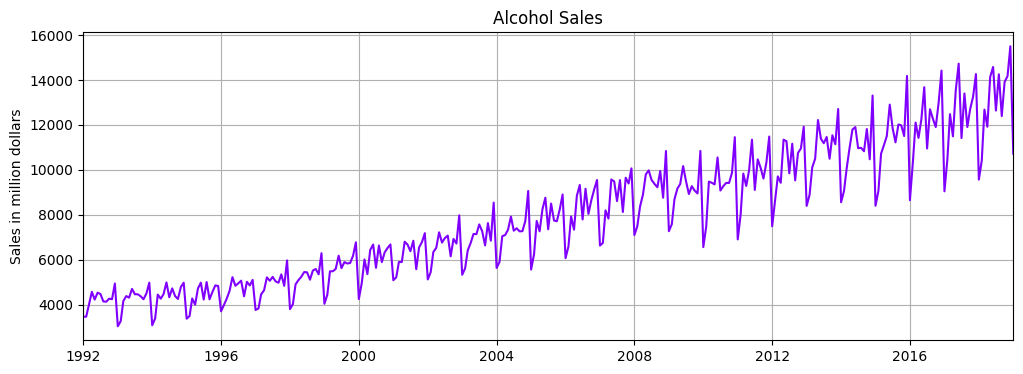

In [45]:
plt.figure(figsize = (12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'],color='#8000ff')
plt.show()

#### 5.2 Prepare and normalize <a id=15></a>

##### 5.2.1 Preparing the data

In [46]:
#extracting the time series values
y = df['S4248SM144NCEN'].values.astype(float) 

#defining a test size
test_size = 12

#create train and test splits
train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

##### 5.2.2 Normalize the data

In [47]:
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

##### 5.2.3 Prepare data for LSTM model

In [48]:
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# define a window size
window_size = 12
# define a function to create sequence/label tuples
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# apply input_data to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

301

##### 5.2.4 Printing the first tuple

In [49]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [50]:
train_dataset = CustomDataset(train_data)

batch_size = 1
n_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,       
                                           shuffle=True, 
                                           num_workers=n_workers,
                                           collate_fn=collate_fn_seq
                                           )

In [51]:
seq, label = next(iter(train_loader))
print(seq.shape, label.shape)

torch.Size([12, 1, 1]) torch.Size([1, 1])


/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(sequence, dtype=torch.float32).view(-1, 1)
/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


#### 5.3 Modelling <a id=16></a>

##### 5.3.1 Instantiation, loss and optimizer

In [52]:
torch.manual_seed(42)

# instantiate
model = LSTMnetwork()

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

model

LSTMnetwork(
  (lstm): LSTM(1, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

##### 5.3.2 Training

In [53]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(sequence, dtype=torch.float32).view(-1, 1)
/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_23934/1625137235.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


Epoch:  1 Loss: 0.00152992
Epoch:  2 Loss: 0.00843880
Epoch:  3 Loss: 0.00020558
Epoch:  4 Loss: 0.01413869
Epoch:  5 Loss: 0.02004326
Epoch:  6 Loss: 0.00073334
Epoch:  7 Loss: 0.03353266
Epoch:  8 Loss: 0.02970750
Epoch:  9 Loss: 0.01011691
Epoch: 10 Loss: 0.05559536
Epoch: 11 Loss: 0.03944287
Epoch: 12 Loss: 0.06183694
Epoch: 13 Loss: 0.18502812
Epoch: 14 Loss: 0.04895264
Epoch: 15 Loss: 0.05617938
Epoch: 16 Loss: 0.02890556
Epoch: 17 Loss: 0.00791390
Epoch: 18 Loss: 0.03782437
Epoch: 19 Loss: 0.00049120
Epoch: 20 Loss: 0.01857182
Epoch: 21 Loss: 0.00185594
Epoch: 22 Loss: 0.01246344
Epoch: 23 Loss: 0.00849931
Epoch: 24 Loss: 0.00207932
Epoch: 25 Loss: 0.00985273
Epoch: 26 Loss: 0.03278357
Epoch: 27 Loss: 0.06656817
Epoch: 28 Loss: 0.04456343
Epoch: 29 Loss: 0.00000738
Epoch: 30 Loss: 0.00257111
Epoch: 31 Loss: 0.00006642
Epoch: 32 Loss: 0.00007244
Epoch: 33 Loss: 0.04788851
Epoch: 34 Loss: 0.00355913
Epoch: 35 Loss: 0.00144676
Epoch: 36 Loss: 0.01318445
Epoch: 37 Loss: 0.07947479
E

##### 5.3.3 visualize gradients norm 


In [54]:
from matplotlib.lines import Line2D

In [55]:
@torch.no_grad()
def plot_grad_flow(named_params):

    avg_grads, max_grads, layers = [], [], []
    # plt.figure(figsize = ((10,20)))
    
    for n, p in named_params:
        
        if (p.requires_grad) and ('bias' not in n):
            
            layers.append(n)
            avg_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
        
    plt.bar(np.arange(len(max_grads)), max_grads, alpha = 0.1, lw = 1, color = 'c')
    plt.bar(np.arange(len(max_grads)), avg_grads, alpha = 0.1, lw = 1, color = 'b')
    plt.hlines(0, 0, len(avg_grads) + 1, lw = 2, color = 'k')
    plt.xticks(range(0, len(avg_grads), 1), layers, rotation = 'vertical')
    plt.xlim(left = 0, right = len(avg_grads))
    plt.ylim(bottom = -0.001, top = 0.02) #Zoom into the lower gradient regions
    plt.xlabel('Layers')
    plt.ylabel('Average Gradients')
    plt.title('Gradient Flow')
    plt.grid(True)
    plt.legend([
        Line2D([0], [0], color = 'c', lw = 4),
        Line2D([0], [0], color = 'b', lw = 4),
        Line2D([0], [0], color = 'k', lw = 4),
        ],
        ['max-gradient', 'mean-gradient','zero-gradient'])
    
    # plt.savefig(path)
    plt.show()
    plt.close()

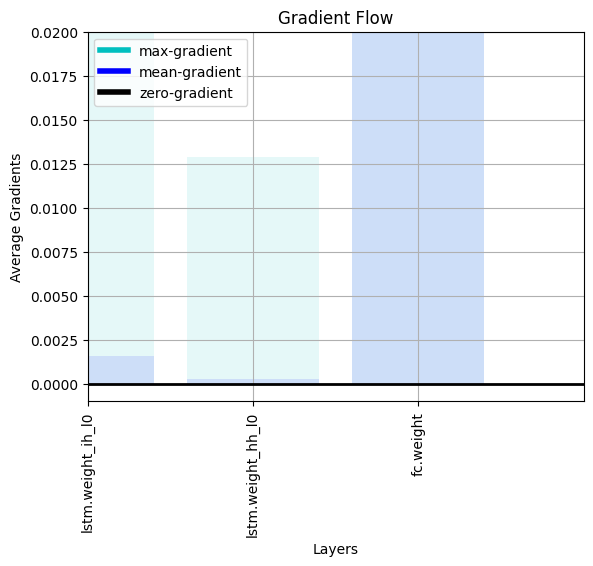

In [56]:
plot_grad_flow(model.named_parameters())
# list(model.named_parameters())

#### 5.4 Predictions <a id=17></a>

##### 5.4.1 Test set predictions

In [57]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

with torch.inference_mode():
    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            preds.append(model(seq.view(len(seq), 1, -1)).item())

preds[window_size:]

[0.37137311697006226,
 0.7129079699516296,
 0.5493106842041016,
 0.9226094484329224,
 0.9638822078704834,
 0.5835722088813782,
 0.8948710560798645,
 0.5635080337524414,
 0.7762057781219482,
 0.849309504032135,
 0.9077656269073486,
 0.1651841700077057]

##### 5.4.2 Original test set

In [58]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

##### 5.4.3 Inverting the normalised values

In [59]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[11052.84704772],
       [13050.65517023],
       [12093.69284725],
       [14277.30396861],
       [14518.72897494],
       [12294.10563585],
       [14115.04824254],
       [12176.74024343],
       [13420.91569912],
       [13848.53594384],
       [14190.47503459],
       [ 9846.74480246]])

##### 5.4.4 Plotting

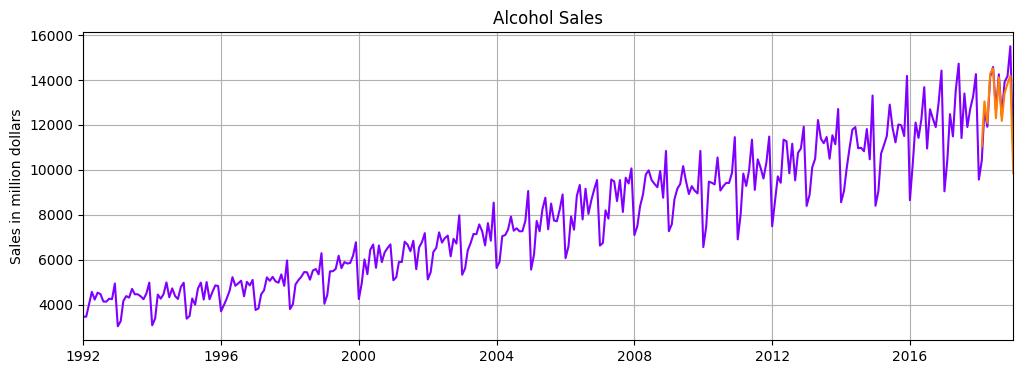

In [60]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

##### 5.5.5 Zooming the test predictions

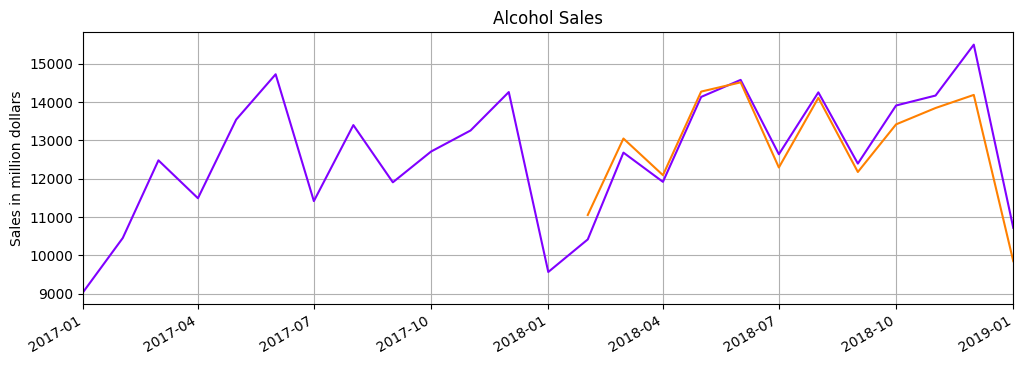

In [61]:
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()